# BB84 QKD Parameters Optimization

## Fiber Lengths and n_X Values
Fiber lengths are created from 0 to 200 km in 0.1 km steps, resulting in 2001 unique fiber lengths. \
$n_X$ values are used ranging from $10^6$ to $10^{10}$, creating 5 unique values. \
Form all combinations of fiber lengths and $n_X$, resulting in 2001 $\times$ 5 = 10,005 combinations, which aligns with the aim to generate a large dataset.

## Optimization Process:
For each combination of fiber length $L$ and $n_X$, The parameters $\vec{p}$ = $ [ \mu_1, \mu_2, P_{\mu_1}, P_{\mu_2}, P_X ]$ are optimized using dual_annealing, which is a global optimization algorithm. \
The objective function is wrapped to evaluate the key rate for a specific combination of fiber length and $n_X$. 

## Parallelization:
joblib’s Parallel is used to run the optimization for all combinations in parallel, with 12 threads, making the process efficient. \
tqdm-joblib is also used to track progress visually. 

## Dataset Creation:
The results of the optimization ($e_1, e_2, e_3, e_4, n_X, R, p_{opt}$) are collected into a dataset. \
This dataset is saved to a file (training_dataset.json) for training a neural network. 




## Setup

### Framework Selection:JAX
Functional Programming: Simplify scientific computation and optimization workflows. \
Smaller Footprint: Ideal if the project doesn’t leverage TensorFlow’s broader ecosystem.

##### Key Considerations
For numerically intensive workloads (e.g., optimization tasks like QKD key rate calculations), JAX excels due to its lightweight functional paradigm.

##### Conclusion
Use JAX for performance-critical, purely numerical optimization tasks with minimal dependencies on machine learning frameworks.

## Imports

In [1]:
import torch
import numpy as np
from tqdm import tqdm
import time
import json
from joblib import Parallel, delayed
from tqdm_joblib import tqdm_joblib

/Users/daai6ga1hou2/anaconda3/envs/qkd-training_set/lib/python3.9/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Experimental Parameters

In [3]:
# e_1
# Fiber lengths
Ls = jnp.linspace(5, 200, 100)  # Fiber lengths in km
L_BC = Ls
e_1 = L_BC / 100
    
#e_2
P_dc_value = 6*10**-7  # Dark count probability
Y_0 = P_dc_value
# 2.7*10** -7
# P_dc = 6 * 10 ** (-7)   # given in the paper, discussed with range from 10^-8 to 10^-5
# e_2 = -jnp.log(Y_0)

# e_3
e_mis = 5 * 10 ** -3  # Misalignment error probability
# 0.026 
e_d = e_mis
e_3 = e_d * 100
e_mis = 5*1e-3 # given in the paper, discussed with range from 0 to 0.1 

# e_4
# Detected events
n_X_values = [10 ** s for s in range(11, 15)]  # Detected events
# n_X_values = jnp.array([10**s for s in range(6, 11)], dtype=jnp.int64)
N = n_X_values
e_4 = N

## Other Parameters

In [4]:
alpha = 0.2  # Attenuation coefficient (dB/km), given in the paper
eta_Bob = 0.1  # Detector efficiency, given in the paper
P_ap = 0  # After-pulse probability
f_EC = 1.16  # Error correction efficiency
# secutity error 
epsilon_sec = 1e-10 # is equal to kappa * secrecy length Kl, range around 1e-10 Scalar, as it is a single value throughout the calculations.
# correlation error
epsilon_cor = 1e-15 # given in the paper, discussed with range from 0 to 10e-10
# Dark count probability
n_event = 1  # for single photon event
# Misalignment error probability
# 4*1e-2          # given in the paper, discussed with range from 0 to 0.1
kappa = 1e-15           # given in the paper
f_EC = 1.16             # given in the paper, range around 1.1


## Optimal Paramters

In [5]:
# p, optimal parameters
# p_1 = mu_1 = 6e-1
# p_2 = mu_2 = 2e-1
# mu_3 = 2e-4
# mu_k_values = [mu_1, mu_2, mu_3]
# p_3 = P_mu_1 = 0.65
# p_4 = P_mu_2 = 0.3
# P_mu_3 = 1 - P_mu_1 - P_mu_2
# p_mu_k_values = [P_mu_1, P_mu_2, P_mu_3]
# p_5 = P_X_value = 5e-3
# P_Z_value = 1 - P_X_value
def optimal_parameters(params):
    mu_1, mu_2, P_mu_1, P_mu_2, P_X_value = params
    mu_3 = 2e-4
    P_mu_3 = 1 - P_mu_1 - P_mu_2
    P_Z_value = 1 - P_X_value
    mu_k_values = jnp.array([mu_1, mu_2, mu_3])
    return params, mu_3, P_mu_3, P_Z_value, mu_k_values

## Functions

The calculate_factorial function provided uses the gamma function to compute the factorial of a number  n . This is mathematically correct because the gamma function  \Gamma(n+1)  is equivalent to the factorial  n!  for non-negative integers  n .

## Mathematical Background
The gamma function is defined as:
$\Gamma(x) = \int_0^\infty t^{x-1} e^{-t} \, dt$ \
For positive integers, the gamma function satisfies the relationship: \
$\Gamma(n + 1) = n!$
\
JAX does not have a built-in factorial function, but it does support the gamma function. This makes the approach valid and compatible with JAX for automatic differentiation and JIT compilation.

In [6]:
from QKD_Functions.QKD_Functions import (
    calculate_factorial,
    calculate_tau_n,
    calculate_eta_ch,
    calculate_eta_sys,
    calculate_D_mu_k,
    calculate_n_X_total,
    calculate_N,
    calculate_n_Z_total,
    calculate_e_mu_k,
    calculate_e_obs,
    calculate_h,
    calculate_lambda_EC,
    calculate_sqrt_term,
    calculate_tau_n,
    calculate_n_pm, 
    calculate_S_0,
    calculate_S_1,
    calculate_m_mu_k,
    calculate_m_pm,
    calculate_v_1,
    calculate_gamma,
    calculate_Phi,
    calculate_LastTwoTerm,
    calculate_l,
    calculate_R,
    experimental_parameters,
    other_parameters,
    calculate_key_rates_and_metrics,
    penalty, 
    objective,
    objective_with_logging
)

In [7]:
# Bounds for optimization parameters
bounds = [
    (1*1e-6, 1),  # mu_1, if it represents a mean photon number, adjust max as needed
    (1*1e-6, 1),  # mu_2
    (1*1e-6, 1),   # P_mu_1, probability
    (1*1e-6, 1),   # P_mu_2, probability
    (1*1e-6, 1),   # P_X_value, probability
]

The function optimize_single_instance is designed to optimize the secret key rate in a Quantum Key Distribution (QKD) system for a given fiber length (L) and number of detected events (n_X). The optimization is performed using a combination of global optimization and local refinement, with safeguards to ensure the solution remains within specified parameter bounds. If abnormal values are detected, the function retries optimization up to a specified number of attempts.

Parameters

	•	input_params: Tuple containing (L, n_X), representing fiber length and detected events.

	•	bounds: Bounds for the optimization parameters to ensure realistic values.

	•	alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event: Physical and system parameters required for key rate calculation.
	
•	max_retries: The maximum number of retries if optimization fails or returns abnormal results (default is 10).

Steps in the Optimization Process

	1.	Objective Function Definition:

A nested function wrapped_objective(params) is defined to evaluate the objective function. It calls the objective() function with system parameters and returns the negative key rate, as the optimization algorithms minimize by default, while the goal is to maximize the key rate.

2.	Optimization Process:

The function employs a two-step optimization approach:

	•	Step 1: Global Optimization (Dual Annealing)
The dual_annealing algorithm is used to perform a global search over the parameter space within the given bounds. This helps to avoid local minima.

	•	Step 2: Local Refinement (Nelder-Mead)
After obtaining an initial estimate from global optimization, a local refinement is performed using the Nelder-Mead algorithm to fine-tune the parameters for better precision.

	3.	Validation and Retry Mechanism:
After obtaining the optimized key rate and parameters, several checks are performed:
	•	Boundary Validation:
Ensures the optimized parameters remain within the specified bounds.

•	Abnormal Key Rate Detection:
If the logarithm of the key rate is greater than zero (indicating an unexpected value), the optimization is retried.

•	Convergence Check:
If the parameters stabilize (i.e., the results do not change significantly across iterations), the process is stopped early.

	4.	Error Handling:
If an exception occurs during optimization, it is caught and logged, and the function retries up to the maximum allowed attempts.

	5.	Returning Results:
If the optimization is successful, the function returns the optimized parameters and key rate. If all retry attempts fail, NaN values are returned to indicate failure.

In [8]:
def optimize_single_instance(input_params, bounds, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event, max_retries=20):
    """
Optimize key rates for a given fiber length and n_X value using dual annealing 
    and Nelder-Mead optimization, ensuring parameters remain within bounds and retry
    if log10(key_rate) > 0.
    """
    L, n_X = input_params

    def wrapped_objective(params):
        # Negative because we minimize, but key rates need maximization
        return -objective(params, L, n_X, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event)[0]

    best_key_rate = float('-inf')
    best_params = None

    for attempt in range(max_retries):
        try:
            # Step 1: Perform global optimization using dual annealing
            global_result = dual_annealing(func=wrapped_objective, bounds=bounds)

            # Step 2: Refine results using local optimization (Nelder-Mead)
            local_result = minimize(
                fun=wrapped_objective,
                x0=global_result.x,  # Start from global optimization result
                method='Nelder-Mead',
                options={'maxiter': 500, 'xatol': 1e-6, 'fatol': 1e-6}  # Tighten tolerances
            )

            # Extract the optimized parameters and key rate
            optimized_params = local_result.x
            optimized_key_rate = -local_result.fun  # Convert back to key rate (positive)

            # Validate the optimized parameters against the bounds
            out_of_bounds = any(
                param < b[0] or param > b[1]
                for param, b in zip(optimized_params, bounds)
            )

            # Retry if key rate is abnormal (log10(key_rate) > 0)
            if np.log10(max(optimized_key_rate, 1e-10)) > 0:
                print(f"Attempt {attempt + 1}: Abnormal key rate detected (log10 > 0). Retrying...")
                continue

            if not out_of_bounds:
                # If all parameters are valid, update best results if key rate is improved
                if optimized_key_rate > best_key_rate:
                    best_key_rate = optimized_key_rate
                    best_params = optimized_params

                # Stop retrying if parameters stabilize
                if best_params is not None and np.allclose(best_params, optimized_params, atol=1e-4):
                    break
            else:
                print(f"Attempt {attempt + 1}: Parameters out of bounds. Retrying...")

        except Exception as e:
            print(f"Attempt {attempt + 1}: Optimization error: {e}. Retrying...")

    if best_params is not None:
        return L, n_X, best_key_rate, best_params

    # If we exhaust retries, raise an error or return NaN results
    print(f"Optimization failed after {max_retries} retries.")
    return L, n_X, float('nan'), [float('nan')] * len(bounds)

Step 1: Define Input Parameters

Define input parameters for a single instance
single_input = (Ls[0], n_X_values[0])  # Example: first fiber length and first n_X value

In this step, the first fiber length (Ls[0]) and the first detected events value (n_X_values[0]) are selected as the input parameters. These values represent a single instance of the optimization problem where:
	•	Ls is an array of fiber lengths (e.g., in kilometers).
	•	n_X_values is an array representing the number of detected events.

Selecting the first elements from these arrays provides an initial scenario to test the optimization function.

Step 2: Measure Execution Time (Start Timer)

Measure start time
start_time = time.time()

To assess the computational efficiency of the optimization, the time.time() function is called to capture the starting time before the optimization process begins.

Step 3: Run the Optimization

Run the optimization for the single instance
L, n_X, optimized_key_rate, optimized_params = optimize_single_instance(
    single_input, bounds, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event
)

The optimize_single_instance() function is executed with the specified input parameters, and it returns the following values:
	•	L: The fiber length used in the optimization.
	•	n_X: The number of detected events.
	•	optimized_key_rate: The computed secret key rate based on the optimized parameters.
	•	optimized_params: A list of optimized values for key system parameters.

The function takes several system parameters as inputs, including:
	•	bounds: The allowable range for optimization variables.
	•	alpha: The attenuation coefficient (e.g., dB/km).
	•	eta_Bob: The detector efficiency.
	•	P_dc_value: The dark count probability.
	•	epsilon_sec, epsilon_cor: Security and correctness error parameters.
	•	f_EC: The error correction efficiency.
	•	e_mis: The misalignment error probability.
	•	P_ap: The after-pulse probability.
	•	n_event: The number of photon events considered.

This function internally uses optimization techniques such as dual annealing and Nelder-Mead to find the best possible parameter values that maximize the secret key rate.

Step 4: Measure Execution Time (End Timer)

Measure end time
end_time = time.time()

Once the optimization process completes, the time.time() function is called again to record the end time, allowing for the calculation of the total execution duration.

Step 5: Organize and Display Results

Output the results with parameter names
parameter_names = ["mu_1", "mu_2", "P_mu_1", "P_mu_2", "P_X_value"]
optimized_parameters = {name: value for name, value in zip(parameter_names, optimized_params)}

In this step, the optimized parameter values are associated with meaningful names to facilitate interpretation. The parameters correspond to:
	•	mu_1: The first photon intensity level.
	•	mu_2: The second photon intensity level.
	•	P_mu_1: The probability associated with mu_1.
	•	P_mu_2: The probability associated with mu_2.
	•	P_X_value: The probability of choosing the X basis in the BB84 protocol.

The zip() function pairs each optimized parameter value with its corresponding name to create a dictionary for organized representation.

Step 6: Print the Optimization Results

print(f"Optimization for a single instance took {end_time - start_time:.2f} seconds.")
print(f"Fiber Length: {L} km, Detected Events (n_X): {n_X}")
print(f"Optimized Key Rate: {optimized_key_rate:.3e}")
print("Optimized Parameters:")
for name, value in optimized_parameters.items():
    print(f"  {name}: {value:.6f}")

The results are printed in a human-readable format, including:

	1.	Execution Time:
The total optimization time is displayed, calculated as the difference between end_time and start_time.

	2.	Fiber Length and Detected Events:
The specific fiber length and number of detected events used in the optimization instance are shown.

	3.	Optimized Secret Key Rate:
The optimized key rate is displayed in scientific notation for better readability.

	4.	Optimized Parameter Values:
Each parameter value is printed with six decimal places to ensure precision in representation.

This output provides a concise summary of the optimization process and its results.

Conclusion

This script effectively demonstrates the optimization of QKD parameters by:
	1.	Defining input values for a single instance.
	2.	Running the optimization function to obtain the optimal secret key rate.
	3.	Measuring and reporting execution time to evaluate performance.
	4.	Organizing and displaying the results in an informative format.


In [9]:
# Define input parameters for a single instance
single_input = (Ls[0], n_X_values[0])  # Example: first fiber length and first n_X value

# Measure start time
start_time = time.time()

# Run the optimization for the single instance
L, n_X, optimized_key_rate, optimized_params = optimize_single_instance(
    single_input, bounds, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event
)

# Measure end time
end_time = time.time()

# Output the results with parameter names
parameter_names = ["mu_1", "mu_2", "P_mu_1", "P_mu_2", "P_X_value"]
optimized_parameters = {name: value for name, value in zip(parameter_names, optimized_params)}

print(f"Optimization for a single instance took {end_time - start_time:.2f} seconds.")
print(f"Fiber Length: {L} km, Detected Events (n_X): {n_X}")
print(f"Optimized Key Rate: {optimized_key_rate:.3e}")
print("Optimized Parameters:")
for name, value in optimized_parameters.items():
    print(f"  {name}: {value:.6f}")

Optimization for a single instance took 1.76 seconds.
Fiber Length: 5.0 km, Detected Events (n_X): 100000000000
Optimized Key Rate: 1.320e-02
Optimized Parameters:
  mu_1: 0.496306
  mu_2: 0.430253
  P_mu_1: 0.211212
  P_mu_2: 0.770671
  P_X_value: 0.939754


Reasonableness Check for Execution Time:

A single optimization took 1.81 seconds. For 10,000 instances, the time would scale proportionally if no optimizations (e.g., batch parallelism) are applied:

$ \text{Total Time} = 1.81 \times 10,000 \approx 5.03 \, \text{hours}$ 

With 12 CPU cores using joblib, the time should reduce by approximately  1 / 12 :

$ \text{Total Time with 12 CPUs} \approx 5.03 / 12 \approx 25.13 \, \text{minutes}$


## Parallel Dataset Generation Using joblib

In [10]:
# #     return dataset
# def generate_dataset(Ls, n_X_values, bounds, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event):
#     """
#     Generate a dataset by optimizing key rates for various fiber lengths and n_X values.
#     """
#     inputs = [(L, n_X) for L in Ls for n_X in n_X_values]

#     print("Generating dataset...")
#     results = []
#     with tqdm(total=len(inputs), desc="Generating Dataset") as progress_bar:
#         results = Parallel(n_jobs=12)(
#             delayed(optimize_single_instance)(
#                 input_params, bounds, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event
#             )
#             for input_params in inputs
#         )
#         progress_bar.update(len(results))

#     # Process results into a dataset
#     dataset = []
#     for L, n_X, penalized_key_rate, optimized_params in results:
#         # Skip invalid key rates
#         if penalized_key_rate <= 0:
#             print(f"Skipping invalid key rate: {penalized_key_rate}")
#             continue

#         # Extract optimized parameters (ensure the order matches the bounds setup)
#         mu_1, mu_2, P_mu_1, P_mu_2, P_X_value = optimized_params

#         # Compute normalized parameters
#         e_1 = L / 100  # Normalize fiber length
#         e_2 = -jnp.log10(P_dc_value)  # Normalize dark count probability
#         e_3 = e_mis * 100  # Normalize misalignment error probability
#         e_4 = jnp.log10(n_X)  # Normalize number of pulses

#         # Append processed data
#         dataset.append({
#             "e_1": e_1,
#             "e_2": e_2,
#             "e_3": e_3,
#             "e_4": e_4,
#             "key_rate": max(penalized_key_rate, 1e-10),  # Enforce non-negative key rate
#             "optimized_params": {
#                 "mu_1": mu_1,
#                 "mu_2": mu_2,
#                 "P_mu_1": P_mu_1,
#                 "P_mu_2": P_mu_2,
#                 "P_X_value": P_X_value,
#             }
#         })

#     return dataset

## Category in terms of $n_X$

	1.	Using a Dictionary for Categorization:
	•	A dictionary (categorized_dataset) is used to store results grouped by n_X.
	•	The defaultdict(list) automatically initializes an empty list for each unique n_X value.

	2.	Processing and Normalization:
	•	The same normalization is applied to the fiber length (e_1), dark count probability (e_2), misalignment error (e_3), and number of detected pulses (e_4).
	•	Data is appended under its respective n_X category.

	3.	Skipping Invalid Data:
	•	Entries with non-positive key rates are excluded to ensure the dataset contains only valid values.
	
	4.	Efficient Parallel Execution:
	•	joblib.Parallel is used to optimize data processing across multiple CPU cores.


In [11]:
def generate_dataset_by_n_X(Ls, n_X_values, bounds, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event):
    """
    Generate dataset organized by n_X values
    """
    # Initialize dictionary to store results by n_X
    categorized_dataset = {float(n_X): [] for n_X in n_X_values}  # Convert to float for dictionary keys
    
    output_dir = os.path.join(os.path.dirname(os.path.dirname(__file__)), 'Training_Data')
    os.makedirs(output_dir, exist_ok=True)
    
    print("Generating dataset...")
    with tqdm(total=len(Ls) * len(n_X_values), desc="Generating Dataset") as progress_bar:
        for L in Ls:
            for n_X in n_X_values:
                # Convert JAX array to float for the optimization
                n_X_float = float(n_X)
                
                # Optimize parameters for this combination
                result = optimize_single_instance(
                    (L, n_X_float), bounds, alpha, eta_Bob, P_dc_value, 
                    epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event
                )
                
                # Unpack results
                L_val, _, penalized_key_rate, optimized_params = result
                
                # Skip invalid key rates
                if penalized_key_rate <= 0:
                    progress_bar.update(1)
                    continue
                
                # Extract optimized parameters
                mu_1, mu_2, P_mu_1, P_mu_2, P_X_value = optimized_params
                
                # Compute normalized parameters
                e_1 = float(L_val / 100)  # Normalize fiber length
                e_2 = float(-jnp.log10(P_dc_value))  # Normalize dark count probability
                e_3 = float(e_mis * 100)  # Normalize misalignment error probability
                e_4 = float(jnp.log10(n_X_float))  # Normalize number of pulses
                
                # Append processed data into the categorized dictionary
                categorized_dataset[n_X_float].append({
                    "fiber_length": float(L_val),
                    "e_1": e_1,
                    "e_2": e_2,
                    "e_3": e_3,
                    "e_4": e_4,
                    "key_rate": float(max(penalized_key_rate, 1e-10)),
                    "optimized_params": {
                        "mu_1": float(mu_1),
                        "mu_2": float(mu_2),
                        "P_mu_1": float(P_mu_1),
                        "P_mu_2": float(P_mu_2),
                        "P_X_value": float(P_X_value)
                    }
                })
                
                progress_bar.update(1)
    
    # Save the dataset
    with open('training_dataset_by_nx.json', 'w') as f:
        json.dump(categorized_dataset, f, indent=2)
    
    return categorized_dataset

In [12]:
# Step 1: Generate Dataset
Ls = jnp.linspace(5, 200, 100)  # Fiber lengths
n_X_values = [10 ** s for s in range(11, 15, 1)]  # n_X values

print("Starting dataset generation...")
start_time = time.time()

# Generate dataset
dataset = generate_dataset_by_n_X(
    Ls, n_X_values, bounds, alpha, eta_Bob, P_dc_value, 
    epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event
)

end_time = time.time()
print(f"Dataset generation completed in {(end_time - start_time)/60:.2f} minutes")

# Save dataset
output_filename = "qkd_dataset_high_nx.json"
with open(output_filename, 'w') as f:
    json.dump(dataset, f, indent=2)

print(f"Dataset saved to {output_filename}")

Starting dataset generation...
Generating dataset...


Generating Dataset:  46%|████▌     | 182/400 [04:35<05:27,  1.50s/it]

Attempt 1: Abnormal key rate detected (log10 > 0). Retrying...


Generating Dataset:  61%|██████    | 243/400 [06:08<03:56,  1.51s/it]

Attempt 1: Parameters out of bounds. Retrying...


Generating Dataset:  62%|██████▎   | 250/400 [06:20<03:53,  1.55s/it]

Attempt 1: Abnormal key rate detected (log10 > 0). Retrying...


Generating Dataset:  71%|███████   | 284/400 [07:12<02:49,  1.46s/it]

Attempt 1: Abnormal key rate detected (log10 > 0). Retrying...


Generating Dataset:  87%|████████▋ | 347/400 [08:46<01:18,  1.47s/it]

Attempt 1: Abnormal key rate detected (log10 > 0). Retrying...


Generating Dataset:  91%|█████████▏| 365/400 [09:14<00:51,  1.46s/it]

Attempt 1: Parameters out of bounds. Retrying...


Generating Dataset:  95%|█████████▌| 380/400 [09:39<00:31,  1.56s/it]

Attempt 1: Parameters out of bounds. Retrying...


Generating Dataset:  96%|█████████▌| 384/400 [09:46<00:25,  1.62s/it]

Attempt 1: Parameters out of bounds. Retrying...
Attempt 2: Parameters out of bounds. Retrying...
Attempt 3: Parameters out of bounds. Retrying...


Generating Dataset:  96%|█████████▋| 385/400 [09:52<00:43,  2.89s/it]

Attempt 1: Parameters out of bounds. Retrying...
Attempt 2: Parameters out of bounds. Retrying...
Attempt 3: Parameters out of bounds. Retrying...


Generating Dataset:  97%|█████████▋| 388/400 [10:01<00:31,  2.61s/it]

Attempt 1: Parameters out of bounds. Retrying...
Attempt 2: Abnormal key rate detected (log10 > 0). Retrying...
Attempt 3: Parameters out of bounds. Retrying...
Attempt 4: Parameters out of bounds. Retrying...
Attempt 5: Parameters out of bounds. Retrying...
Attempt 6: Parameters out of bounds. Retrying...
Attempt 7: Parameters out of bounds. Retrying...
Attempt 8: Parameters out of bounds. Retrying...
Attempt 9: Parameters out of bounds. Retrying...
Attempt 10: Parameters out of bounds. Retrying...
Attempt 11: Parameters out of bounds. Retrying...
Attempt 12: Parameters out of bounds. Retrying...
Attempt 13: Parameters out of bounds. Retrying...
Attempt 14: Parameters out of bounds. Retrying...
Attempt 15: Parameters out of bounds. Retrying...
Attempt 16: Parameters out of bounds. Retrying...
Attempt 17: Parameters out of bounds. Retrying...
Attempt 18: Parameters out of bounds. Retrying...
Attempt 19: Parameters out of bounds. Retrying...


Generating Dataset:  97%|█████████▋| 389/400 [10:30<01:56, 10.57s/it]

Attempt 20: Parameters out of bounds. Retrying...
Optimization failed after 20 retries.
Attempt 1: Parameters out of bounds. Retrying...


Generating Dataset:  98%|█████████▊| 390/400 [10:33<01:22,  8.27s/it]

Attempt 1: Parameters out of bounds. Retrying...
Attempt 2: Parameters out of bounds. Retrying...
Attempt 3: Parameters out of bounds. Retrying...
Attempt 4: Parameters out of bounds. Retrying...
Attempt 5: Parameters out of bounds. Retrying...
Attempt 6: Parameters out of bounds. Retrying...
Attempt 7: Parameters out of bounds. Retrying...
Attempt 8: Parameters out of bounds. Retrying...
Attempt 9: Parameters out of bounds. Retrying...
Attempt 10: Parameters out of bounds. Retrying...
Attempt 11: Parameters out of bounds. Retrying...
Attempt 12: Parameters out of bounds. Retrying...
Attempt 13: Parameters out of bounds. Retrying...
Attempt 14: Parameters out of bounds. Retrying...
Attempt 15: Parameters out of bounds. Retrying...
Attempt 16: Parameters out of bounds. Retrying...
Attempt 17: Parameters out of bounds. Retrying...
Attempt 18: Parameters out of bounds. Retrying...
Attempt 19: Parameters out of bounds. Retrying...


Generating Dataset:  98%|█████████▊| 391/400 [11:02<02:10, 14.51s/it]

Attempt 20: Parameters out of bounds. Retrying...
Optimization failed after 20 retries.
Attempt 1: Parameters out of bounds. Retrying...
Attempt 2: Parameters out of bounds. Retrying...
Attempt 3: Parameters out of bounds. Retrying...
Attempt 4: Parameters out of bounds. Retrying...
Attempt 5: Parameters out of bounds. Retrying...
Attempt 6: Parameters out of bounds. Retrying...
Attempt 7: Parameters out of bounds. Retrying...
Attempt 8: Parameters out of bounds. Retrying...
Attempt 9: Parameters out of bounds. Retrying...
Attempt 10: Parameters out of bounds. Retrying...
Attempt 11: Parameters out of bounds. Retrying...
Attempt 12: Parameters out of bounds. Retrying...
Attempt 13: Parameters out of bounds. Retrying...
Attempt 14: Parameters out of bounds. Retrying...
Attempt 15: Parameters out of bounds. Retrying...
Attempt 16: Parameters out of bounds. Retrying...
Attempt 17: Parameters out of bounds. Retrying...
Attempt 18: Parameters out of bounds. Retrying...
Attempt 19: Parameter

Generating Dataset:  98%|█████████▊| 392/400 [11:31<02:30, 18.87s/it]

Attempt 20: Parameters out of bounds. Retrying...
Optimization failed after 20 retries.
Attempt 1: Parameters out of bounds. Retrying...
Attempt 3: Parameters out of bounds. Retrying...
Attempt 4: Parameters out of bounds. Retrying...
Attempt 5: Abnormal key rate detected (log10 > 0). Retrying...
Attempt 6: Parameters out of bounds. Retrying...
Attempt 7: Parameters out of bounds. Retrying...
Attempt 8: Parameters out of bounds. Retrying...
Attempt 9: Parameters out of bounds. Retrying...
Attempt 10: Parameters out of bounds. Retrying...
Attempt 11: Parameters out of bounds. Retrying...
Attempt 12: Parameters out of bounds. Retrying...
Attempt 13: Parameters out of bounds. Retrying...
Attempt 14: Parameters out of bounds. Retrying...
Attempt 15: Parameters out of bounds. Retrying...
Attempt 16: Parameters out of bounds. Retrying...
Attempt 17: Parameters out of bounds. Retrying...
Attempt 18: Parameters out of bounds. Retrying...
Attempt 19: Parameters out of bounds. Retrying...


Generating Dataset:  98%|█████████▊| 393/400 [12:01<02:34, 22.06s/it]

Attempt 20: Parameters out of bounds. Retrying...
Optimization failed after 20 retries.
Attempt 1: Parameters out of bounds. Retrying...
Attempt 2: Abnormal key rate detected (log10 > 0). Retrying...
Attempt 3: Parameters out of bounds. Retrying...
Attempt 4: Parameters out of bounds. Retrying...
Attempt 5: Parameters out of bounds. Retrying...
Attempt 6: Parameters out of bounds. Retrying...
Attempt 7: Parameters out of bounds. Retrying...
Attempt 8: Parameters out of bounds. Retrying...
Attempt 9: Parameters out of bounds. Retrying...
Attempt 10: Parameters out of bounds. Retrying...
Attempt 11: Parameters out of bounds. Retrying...
Attempt 12: Parameters out of bounds. Retrying...
Attempt 13: Parameters out of bounds. Retrying...
Attempt 14: Parameters out of bounds. Retrying...
Attempt 15: Abnormal key rate detected (log10 > 0). Retrying...
Attempt 16: Parameters out of bounds. Retrying...
Attempt 17: Parameters out of bounds. Retrying...
Attempt 18: Parameters out of bounds. Retry

Generating Dataset:  98%|█████████▊| 394/400 [12:30<02:24, 24.14s/it]

Attempt 20: Parameters out of bounds. Retrying...
Optimization failed after 20 retries.
Attempt 1: Parameters out of bounds. Retrying...
Attempt 2: Parameters out of bounds. Retrying...
Attempt 3: Parameters out of bounds. Retrying...
Attempt 4: Parameters out of bounds. Retrying...
Attempt 5: Parameters out of bounds. Retrying...
Attempt 6: Parameters out of bounds. Retrying...
Attempt 7: Parameters out of bounds. Retrying...
Attempt 8: Abnormal key rate detected (log10 > 0). Retrying...
Attempt 9: Parameters out of bounds. Retrying...
Attempt 10: Parameters out of bounds. Retrying...
Attempt 11: Parameters out of bounds. Retrying...
Attempt 12: Abnormal key rate detected (log10 > 0). Retrying...
Attempt 13: Parameters out of bounds. Retrying...
Attempt 14: Parameters out of bounds. Retrying...
Attempt 15: Parameters out of bounds. Retrying...
Attempt 16: Parameters out of bounds. Retrying...
Attempt 17: Parameters out of bounds. Retrying...
Attempt 18: Parameters out of bounds. Retry

Generating Dataset:  99%|█████████▉| 395/400 [12:59<02:08, 25.73s/it]

Attempt 20: Parameters out of bounds. Retrying...
Optimization failed after 20 retries.
Attempt 1: Parameters out of bounds. Retrying...
Attempt 2: Parameters out of bounds. Retrying...
Attempt 3: Parameters out of bounds. Retrying...
Attempt 4: Parameters out of bounds. Retrying...
Attempt 5: Parameters out of bounds. Retrying...
Attempt 6: Parameters out of bounds. Retrying...
Attempt 7: Parameters out of bounds. Retrying...
Attempt 8: Parameters out of bounds. Retrying...
Attempt 9: Parameters out of bounds. Retrying...
Attempt 10: Abnormal key rate detected (log10 > 0). Retrying...
Attempt 11: Parameters out of bounds. Retrying...
Attempt 12: Parameters out of bounds. Retrying...
Attempt 13: Parameters out of bounds. Retrying...
Attempt 14: Parameters out of bounds. Retrying...
Attempt 15: Parameters out of bounds. Retrying...
Attempt 16: Parameters out of bounds. Retrying...
Attempt 17: Parameters out of bounds. Retrying...
Attempt 18: Parameters out of bounds. Retrying...
Attempt

Generating Dataset:  99%|█████████▉| 396/400 [13:28<01:47, 26.76s/it]

Attempt 20: Parameters out of bounds. Retrying...
Optimization failed after 20 retries.
Attempt 1: Parameters out of bounds. Retrying...
Attempt 2: Parameters out of bounds. Retrying...
Attempt 3: Parameters out of bounds. Retrying...
Attempt 4: Parameters out of bounds. Retrying...
Attempt 5: Parameters out of bounds. Retrying...
Attempt 6: Parameters out of bounds. Retrying...
Attempt 7: Parameters out of bounds. Retrying...
Attempt 8: Parameters out of bounds. Retrying...
Attempt 9: Parameters out of bounds. Retrying...
Attempt 10: Parameters out of bounds. Retrying...
Attempt 11: Parameters out of bounds. Retrying...
Attempt 12: Parameters out of bounds. Retrying...
Attempt 13: Parameters out of bounds. Retrying...
Attempt 14: Parameters out of bounds. Retrying...
Attempt 15: Parameters out of bounds. Retrying...
Attempt 16: Parameters out of bounds. Retrying...
Attempt 17: Parameters out of bounds. Retrying...
Attempt 18: Parameters out of bounds. Retrying...
Attempt 19: Parameter

Generating Dataset:  99%|█████████▉| 397/400 [13:57<01:22, 27.44s/it]

Attempt 20: Parameters out of bounds. Retrying...
Optimization failed after 20 retries.
Attempt 1: Parameters out of bounds. Retrying...
Attempt 2: Parameters out of bounds. Retrying...
Attempt 3: Parameters out of bounds. Retrying...
Attempt 4: Parameters out of bounds. Retrying...
Attempt 5: Parameters out of bounds. Retrying...
Attempt 6: Abnormal key rate detected (log10 > 0). Retrying...
Attempt 7: Parameters out of bounds. Retrying...
Attempt 8: Parameters out of bounds. Retrying...
Attempt 9: Parameters out of bounds. Retrying...
Attempt 10: Parameters out of bounds. Retrying...
Attempt 11: Parameters out of bounds. Retrying...
Attempt 12: Parameters out of bounds. Retrying...
Attempt 13: Parameters out of bounds. Retrying...
Attempt 14: Parameters out of bounds. Retrying...
Attempt 15: Parameters out of bounds. Retrying...
Attempt 16: Parameters out of bounds. Retrying...
Attempt 17: Parameters out of bounds. Retrying...
Attempt 18: Parameters out of bounds. Retrying...
Attempt

Generating Dataset: 100%|█████████▉| 398/400 [14:26<00:55, 27.95s/it]

Attempt 20: Parameters out of bounds. Retrying...
Optimization failed after 20 retries.
Attempt 1: Parameters out of bounds. Retrying...
Attempt 2: Parameters out of bounds. Retrying...
Attempt 3: Parameters out of bounds. Retrying...
Attempt 4: Parameters out of bounds. Retrying...
Attempt 5: Parameters out of bounds. Retrying...
Attempt 6: Parameters out of bounds. Retrying...
Attempt 7: Parameters out of bounds. Retrying...
Attempt 8: Parameters out of bounds. Retrying...
Attempt 9: Parameters out of bounds. Retrying...
Attempt 10: Parameters out of bounds. Retrying...
Attempt 11: Parameters out of bounds. Retrying...
Attempt 12: Parameters out of bounds. Retrying...
Attempt 13: Parameters out of bounds. Retrying...
Attempt 14: Parameters out of bounds. Retrying...
Attempt 15: Parameters out of bounds. Retrying...
Attempt 16: Parameters out of bounds. Retrying...
Attempt 17: Parameters out of bounds. Retrying...
Attempt 18: Parameters out of bounds. Retrying...
Attempt 19: Parameter

Generating Dataset: 100%|█████████▉| 399/400 [14:55<00:28, 28.23s/it]

Attempt 20: Parameters out of bounds. Retrying...
Optimization failed after 20 retries.
Attempt 1: Parameters out of bounds. Retrying...
Attempt 2: Parameters out of bounds. Retrying...
Attempt 3: Parameters out of bounds. Retrying...
Attempt 4: Parameters out of bounds. Retrying...
Attempt 5: Parameters out of bounds. Retrying...
Attempt 6: Parameters out of bounds. Retrying...
Attempt 7: Parameters out of bounds. Retrying...
Attempt 8: Parameters out of bounds. Retrying...
Attempt 9: Parameters out of bounds. Retrying...
Attempt 10: Parameters out of bounds. Retrying...
Attempt 11: Parameters out of bounds. Retrying...
Attempt 12: Parameters out of bounds. Retrying...
Attempt 13: Parameters out of bounds. Retrying...
Attempt 14: Parameters out of bounds. Retrying...
Attempt 15: Parameters out of bounds. Retrying...
Attempt 16: Parameters out of bounds. Retrying...
Attempt 17: Parameters out of bounds. Retrying...
Attempt 18: Parameters out of bounds. Retrying...
Attempt 19: Parameter

Generating Dataset: 100%|██████████| 400/400 [15:24<00:00,  2.31s/it]

Attempt 20: Parameters out of bounds. Retrying...
Optimization failed after 20 retries.
Dataset generation completed in 15.42 minutes
Dataset saved to qkd_dataset_high_nx.json


In [1]:
# Step 2: Load and Plot Dataset
def plot_for_nx(data, target_nx):
    """
    Plot results for a specific n_X value
    """
    # Convert target_nx to string for dictionary key
    nx_key = str(float(target_nx))
    
    if nx_key not in data:
        print(f"No data found for n_X = {target_nx}")
        return
        
    filtered_data = data[nx_key]
    
    if not filtered_data:
        print(f"No valid results for n_X = {target_nx}")
        return
    
    # Extract data
    fiber_lengths = [entry["fiber_length"] for entry in filtered_data]
    key_rates = [entry["key_rate"] for entry in filtered_data]
    
    # Create figure
    plt.figure(figsize=(15, 6))
    
    # Plot key rates
    plt.subplot(1, 2, 1)
    plt.plot(fiber_lengths, np.log10([max(kr, 1e-30) for kr in key_rates]))
    plt.xlabel("Fiber Length (km)")
    plt.ylabel("log10(Key Rate)")
    plt.title(f"Key Rate vs Fiber Length (n_X = {target_nx:.0e})")
    plt.grid(True)
    
    # Plot parameters
    plt.subplot(1, 2, 2)
    params = ["mu_1", "mu_2", "P_mu_1", "P_mu_2", "P_X_value"]
    for param in params:
        values = [entry["optimized_params"][param] for entry in filtered_data]
        plt.plot(fiber_lengths, values, label=param)
    
    plt.xlabel("Fiber Length (km)")
    plt.ylabel("Parameter Value")
    plt.title(f"Optimized Parameters (n_X = {target_nx:.0e})")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f"qkd_results_nx_{target_nx:.0e}.png", dpi=300, bbox_inches="tight")
    plt.show()

# Load the saved dataset
with open("qkd_dataset_high_nx.json", 'r') as f:
    dataset = json.load(f)

# Plot results for each n_X value
for nx in [10**s for s in range(11, 15, 1)]:
    print(f"\nPlotting results for n_X = {nx:.0e}")
    plot_for_nx(dataset, nx)

NameError: name 'json' is not defined

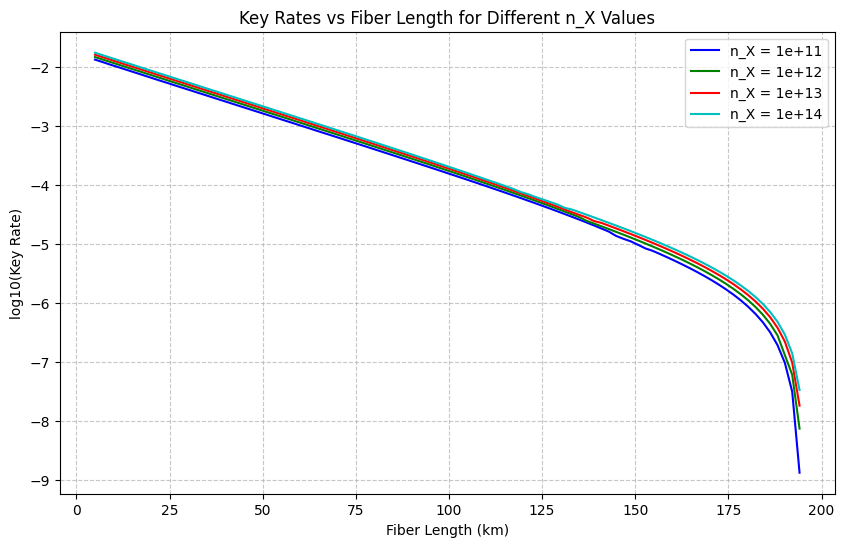

In [23]:
# Load and plot all key rates in one figure
def plot_all_key_rates(dataset):
    plt.figure(figsize=(10, 6))
    
    # Color map for different n_X values
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    
    # Sort n_X values for consistent plotting
    nx_values = sorted([float(nx) for nx in dataset.keys()])
    
    for i, nx in enumerate(nx_values):
        nx_key = str(float(nx))
        data = dataset[nx_key]
        
        if data:
            # Extract and sort by fiber length
            fiber_lengths = [entry["fiber_length"] for entry in data]
            key_rates = [entry["key_rate"] for entry in data]
            
            # Sort data points by fiber length
            sorted_indices = np.argsort(fiber_lengths)
            sorted_lengths = [fiber_lengths[i] for i in sorted_indices]
            sorted_rates = [key_rates[i] for i in sorted_indices]
            
            # Plot with scientific notation in legend
            plt.plot(sorted_lengths, 
                    np.log10([max(kr, 1e-30) for kr in sorted_rates]), 
                    color=colors[i % len(colors)],
                    label=f'n_X = {nx:.0e}')
    
    plt.xlabel("Fiber Length (km)")
    plt.ylabel("log10(Key Rate)")
    plt.title("Key Rates vs Fiber Length for Different n_X Values")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # Save the figure
    plt.savefig("all_key_rates.png", dpi=300, bbox_inches="tight")
    plt.show()

# Load the dataset and create the plot
with open("qkd_dataset_high_nx.json", 'r') as f:
    dataset = json.load(f)

plot_all_key_rates(dataset)

In [14]:
# def plot_grouped_parameters(dataset, n_X_values):
#     """
#     Plot grouped parameters and key rates for multiple n_X values
#     """
#     # Create two subplots: one for key rates, one for other parameters
#     fig, (ax_key_rate, ax_params) = plt.subplots(2, 1, figsize=(15, 20))
    
#     # Plot key rates for each n_X value
#     for n_X in n_X_values:
#         if n_X not in dataset:
#             print(f"No data found for n_X = {n_X}")
#             continue
            
#         data = dataset[n_X]
#         data.sort(key=lambda x: x['fiber_length'])
        
#         fiber_lengths = [d['fiber_length'] for d in data]
#         key_rates = [d['key_rate'] for d in data]
        
#         # Plot key rate
#         ax_key_rate.plot(fiber_lengths, key_rates, label=f'n_X = {n_X:.0e}')
    
#     # Configure key rate plot
#     ax_key_rate.set_xlabel('Fiber Length (km)')
#     ax_key_rate.set_ylabel('Key Rate')
#     ax_key_rate.set_yscale('log')
#     ax_key_rate.grid(True)
#     ax_key_rate.legend()
#     ax_key_rate.set_title('Key Rate vs Fiber Length')
    
#     # Plot other parameters (using first n_X value for parameters)
#     n_X = n_X_values[0]
#     data = dataset[n_X]
#     data.sort(key=lambda x: x['fiber_length'])
    
#     fiber_lengths = [d['fiber_length'] for d in data]
#     params = {
#         'μ₁': [d['optimized_params']['mu_1'] for d in data],
#         'μ₂': [d['optimized_params']['mu_2'] for d in data],
#         'P_μ₁': [d['optimized_params']['P_mu_1'] for d in data],
#         'P_μ₂': [d['optimized_params']['P_mu_2'] for d in data],
#         'P_X': [d['optimized_params']['P_X_value'] for d in data]
#     }
    
#     # Plot each parameter
#     for param_name, values in params.items():
#         ax_params.plot(fiber_lengths, values, label=param_name)
    
#     # Configure parameters plot
#     ax_params.set_xlabel('Fiber Length (km)')
#     ax_params.set_ylabel('Parameter Value')
#     ax_params.set_yscale('log')
#     ax_params.grid(True)
#     ax_params.legend()
#     ax_params.set_title('Optimized Parameters vs Fiber Length')
    
#     plt.tight_layout()
#     plt.show()

# # Usage example:
# if __name__ == "__main__":
#     # Generate dataset for a smaller range first
#     Ls = jnp.linspace(5, 200, 100)  # Fewer points for testing
#     n_X_values = [1e11, 1e12, 1e13, 1e14]  # Just two values for testing
    
#     # Generate the dataset
#     dataset = generate_dataset_by_n_X(
#         Ls, n_X_values, bounds, alpha, eta_Bob, P_dc_value, 
#         epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event
#     )
    
#     # Plot grouped parameters and key rates
#     plot_grouped_parameters(dataset, n_X_values)

In [15]:
# import json

# ad the dataset
#  open('training_dataset_by_nx.json', 'r') as f:
# dataset = json.load(f)

# int number of data points for each n_X
# n_X in dataset:
# print(f"n_X = {float(n_X):.0e}: {len(dataset[n_X])} data points")

In [16]:
# def convert_to_serializable(obj):
#     """
#     Recursively convert JAX arrays and other non-JSON serializable objects
#     to standard Python types.
#     """
#     if isinstance(obj, jnp.ndarray):
#         return obj.tolist()  # Convert JAX array to a Python list
#     elif isinstance(obj, np.ndarray):
#         return obj.tolist()  # Convert NumPy array to a Python list
#     elif isinstance(obj, dict):
#         return {key: convert_to_serializable(value) for key, value in obj.items()}
#     elif isinstance(obj, list):
#         return [convert_to_serializable(item) for item in obj]
#     elif isinstance(obj, tuple):
#         return tuple(convert_to_serializable(item) for item in obj)
#     else:
#         return obj  # Return other types as-is

The script runs the function optimize_single_instance() with a single set of input values (Ls[0] and n_X_values[0]), along with the necessary parameters. 

	•	The execution time is measured and printed.

The script uses the measured runtime for one instance to estimate the total time required to process all total_points = 10,000 data points in parallel using parallel_jobs = 12. 

	•	The estimated total runtime is printed in hours.

In [17]:
# import time

# # Example input parameters
# example_input = (Ls[0], n_X_values[0])

# start_time = time.time()
# # Run the optimization for a single instance
# optimize_single_instance(
#     example_input, bounds, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event
# )
# end_time = time.time()

# # Measure and assign the runtime
# single_instance_time = end_time - start_time
# print(f"Time per single instance: {single_instance_time:.2f} seconds")

# total_points = 100
# parallel_jobs = 12
# time_per_instance = single_instance_time  # e.g., 2 seconds

# # Total instances divided by parallel jobs
# time_estimate = (total_points / parallel_jobs) * time_per_instance

# print(f"Estimated time to generate {total_points} entries: {time_estimate / 3600:.2f} hours")

In [18]:
# Ls = jnp.linspace(1, 200, 100)  # Fiber lengths (5 km to 200 km)
# n_X_values = jnp.logspace(6, 12, 100)  # Detected events (10^6 to 10^10)

# print(f"L ranges from {min(Ls):.2f} to {max(Ls):.2f} km, with {len(Ls)} points.")
# print(f"n_X_values ranges from {min(n_X_values):.2e} to {max(n_X_values):.2e}, with {len(n_X_values)} points.")
# print(f"total {len(Ls) * len(n_X_values)} points, the difference between the optimized datapoint and the data point form the literature is {len(Ls) * len(n_X_values)- 41*10000}")

Parameter Space Definition:

	•	The fiber lengths (Ls) are defined in the range of 1 to 200 km with 100 evenly spaced points.
•	The detected events (n_X_values) are logarithmically spaced from $10^6$￼to $10^{12}$￼, also with 100 points.

Profiling (Optional Debugging):

	•	The script profiles a single optimization instance using cProfile.run(). This step is useful for debugging performance issues but does not contribute to data generation directly.

Raw Dataset Generation:
	
•	The function generate_dataset() is called, which presumably generates key rate values for each combination of Ls and n_X_values based on the provided system parameters (e.g., alpha, eta_Bob, P_dc_value, etc.).

	•	This function should iterate over all combinations of the two parameter arrays, producing a dataset of key rate values.

Filtering Negative Key Rates:

	•	The raw dataset entries are filtered to remove any with non-positive key rates. Only entries where entry["key_rate"] > 0 are retained, ensuring meaningful data.

Serialization to JSON:

	•	The filtered dataset is converted to a JSON-serializable format to ensure compatibility for saving or further processing.

Saving the Data:

	•	The filtered dataset is saved to a JSON file (total_training_dataset.json), making it available for further analysis.

Will This Generate Data Points?

Yes, if the function generate_dataset() is correctly implemented and functional, the script should generate a substantial number of data points. Given the defined ranges, the total number of raw data points before filtering would be:
￼

However, the final number of data points saved depends on the filtering step, which removes entries with non-positive key rates. If too many entries are filtered out, it might reduce the dataset significantly.

Potential Issues to Watch For:

	•	Ensure generate_dataset() is correctly implemented to avoid empty results.

	•	The filtering criteria (key_rate > 0) may remove too many points if parameters are not optimally chosen.

	•	The file-writing step requires that the data be correctly converted to a serializable format, otherwise it may fail.

In [19]:
# # Define parameter space
# Ls = jnp.linspace(1, 200, 10)  # Fiber lengths (5 km to 200 km)
# n_X_values = jnp.logspace(6, 7, 10)  # Detected events (10^6 to 10^12)

# # Profile a single optimization instance (optional debugging)
# import cProfile
# cProfile.run("optimize_single_instance((Ls[0], n_X_values[0]), bounds, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event)")

# # Measure total dataset generation time
# import time
# start_time = time.time()

# # Step 1: Generate the raw dataset
# raw_dataset = generate_dataset_by_n_X(
#     Ls, n_X_values, bounds, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event
# )

# # Step 2: Filter out entries with non-positive key rates
# # Filter out entries with negative key rates
# filtered_dataset = [entry for entry in raw_dataset if entry["key_rate"] > 0]

# end_time = time.time()

# # Step 3: Convert the filtered dataset to a JSON-serializable format
# serializable_dataset = convert_to_serializable(filtered_dataset)

# # Step 4: Save the filtered dataset to a JSON file
# output_filename = "total_training_dataset.json"
# with open(output_filename, "w") as f:
#     json.dump(serializable_dataset, f)

# print(f"Filtered dataset saved as '{output_filename}'.")

In [20]:
# print(f"Raw dataset size: {len(raw_dataset)}")
# key_rates = [entry["key_rate"] for entry in raw_dataset]
# print(f"Number of negative key rates in the dataset: {sum(kr <= 0 for kr in key_rates)}")
# print(f"Number of positive key rates in the dataset: {sum(kr > 0 for kr in key_rates)}")

## $n_X = 10^6$

In [21]:
# # Load the dataset
# with open("total_training_dataset.json", "r") as f:
#     data = json.load(f)

# # Filter dataset for n_X = 10^6
# filtered_data = [item for item in data if item["e_4"] == 1e6]  # Ensure the value matches 1e6

# # Extract fiber lengths and key rates
# e_1 = jnp.array([item["e_1"] * 100 for item in filtered_data])  # Denormalize fiber lengths (convert to km)
# key_rate = jnp.array([item["key_rate"] for item in filtered_data])  # Extract key rates

# # Extract optimized parameters
# mu_1 = jnp.array([item["optimized_params"]["mu_1"] for item in filtered_data])  # Access nested keys
# mu_2 = jnp.array([item["optimized_params"]["mu_2"] for item in filtered_data])
# P_mu_1 = jnp.array([item["optimized_params"]["P_mu_1"] for item in filtered_data])
# P_mu_2 = jnp.array([item["optimized_params"]["P_mu_2"] for item in filtered_data])
# P_X_value = jnp.array([item["optimized_params"]["P_X_value"] for item in filtered_data])

# # Sort by fiber length for smooth plotting
# sorted_indices = jnp.argsort(e_1)
# e_1_sorted = e_1[sorted_indices]
# key_rate_sorted = key_rate[sorted_indices]
# mu_1_sorted = mu_1[sorted_indices]
# mu_2_sorted = mu_2[sorted_indices]
# P_mu_1_sorted = P_mu_1[sorted_indices]
# P_mu_2_sorted = P_mu_2[sorted_indices]
# P_X_value_sorted = P_X_value[sorted_indices]

# # Plot the data
# plt.figure(figsize=(15, 6))

# # Left plot: Penalized Key Rate
# plt.subplot(1, 2, 1)
# plt.plot(e_1_sorted, jnp.log10(jnp.clip(key_rate_sorted, a_min=1e-10, a_max=None)), label="Penalized Key Rate (log10)")
# plt.xlabel("Fiber Length (km)")
# plt.ylabel("log10(Penalized Key Rate)")
# plt.title("Penalized Key Rate vs Fiber Length (n_X = 10^6)")
# plt.grid(True, linestyle='--', linewidth=0.5)
# plt.legend()

# # Right plot: Optimized Parameters
# plt.subplot(1, 2, 2)
# plt.plot(e_1_sorted, mu_1_sorted, label="mu_1")
# plt.plot(e_1_sorted, mu_2_sorted, label="mu_2")
# plt.plot(e_1_sorted, P_mu_1_sorted, label="P_mu_1")
# plt.plot(e_1_sorted, P_mu_2_sorted, label="P_mu_2")
# plt.plot(e_1_sorted, P_X_value_sorted, label="P_X_value")
# plt.xlabel("Fiber Length (km)")
# plt.ylabel("Optimized Parameters")
# plt.title("Optimized Parameters vs Fiber Length (n_X = 10^6)")
# plt.grid(True, linestyle='--', linewidth=0.5)
# plt.legend()

# # Save the figure
# plt.tight_layout()
# plt.savefig("optimized_parameters_nX_10e6.png", dpi=300, bbox_inches="tight")  # Save with high resolution
# plt.show()

In [22]:
# Define parameter space
Ls = jnp.linspace(5, 200, 100)  # Fiber lengths
n_X_values = jnp.array([1e6])  # Single value for n_X

import cProfile
cProfile.run("optimize_single_instance((Ls[0], n_X_values[0]), bounds, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event)")

# Measure total dataset generation time
import time
start_time = time.time()

dataset = generate_dataset(
    Ls, n_X_values, bounds, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event
)

end_time = time.time()
print(f"Dataset generation completed in {(end_time - start_time) / 60:.2f} minutes.")

# Convert dataset to a JSON-serializable format
serializable_dataset = convert_to_serializable(dataset)

# Save to JSON
output_filename = "training_dataset.json"
with open(output_filename, "w") as f:
    json.dump(serializable_dataset, f)

print(f"Dataset saved as '{output_filename}'.")

# Load the dataset
with open("training_dataset.json", "r") as f:
    data = json.load(f)

# Extract fiber lengths and key rates
e_1 = jnp.array([item["e_1"] * 100 for item in data])  # Denormalize fiber lengths (convert to km)
key_rate = jnp.array([item["key_rate"] for item in data])  # Correct key name

# Extract optimized parameters
mu_1 = jnp.array([item["optimized_params"]["mu_1"] for item in data])  # Access nested keys
mu_2 = jnp.array([item["optimized_params"]["mu_2"] for item in data])
P_mu_1 = jnp.array([item["optimized_params"]["P_mu_1"] for item in data])
P_mu_2 = jnp.array([item["optimized_params"]["P_mu_2"] for item in data])
P_X_value = jnp.array([item["optimized_params"]["P_X_value"] for item in data])

# Sort by fiber length for smooth plotting
sorted_indices = jnp.argsort(e_1)
e_1_sorted = e_1[sorted_indices]
key_rate_sorted = key_rate[sorted_indices]
mu_1_sorted = mu_1[sorted_indices]
mu_2_sorted = mu_2[sorted_indices]
P_mu_1_sorted = P_mu_1[sorted_indices]
P_mu_2_sorted = P_mu_2[sorted_indices]
P_X_value_sorted = P_X_value[sorted_indices]

# Plot the data
plt.figure(figsize=(15, 6))

# Left plot: Penalized Key Rate
plt.subplot(1, 2, 1)
plt.plot(e_1_sorted, jnp.log10(jnp.clip(key_rate_sorted, a_min=1e-10, a_max=None)), label="Penalized Key Rate (log10)")
plt.xlabel("Fiber Length (km)")
plt.ylabel("log10(Penalized Key Rate)")
plt.title("Penalized Key Rate vs Fiber Length")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()

# Right plot: Optimized Parameters
plt.subplot(1, 2, 2)
plt.plot(e_1_sorted, mu_1_sorted, label="mu_1")
plt.plot(e_1_sorted, mu_2_sorted, label="mu_2")
plt.plot(e_1_sorted, P_mu_1_sorted, label="P_mu_1")
plt.plot(e_1_sorted, P_mu_2_sorted, label="P_mu_2")
plt.plot(e_1_sorted, P_X_value_sorted, label="P_X_value")
plt.xlabel("Fiber Length (km)")
plt.ylabel("Optimized Parameters")
plt.title("Optimized Parameters vs Fiber Length")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
# Save the figure
plt.tight_layout()
plt.savefig("optimized_parameters_plot.png", dpi=300, bbox_inches="tight")  # Save with high resolution
plt.show()

         3224292 function calls (3215673 primitive calls) in 1.967 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    1.955    1.955 1256058694.py:1(optimize_single_instance)
        6    0.000    0.000    0.000    0.000 1256058694.py:34(<genexpr>)
    10308    0.107    0.000    1.411    0.000 1256058694.py:9(wrapped_objective)
       49    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1033(_handle_fromlist)
        6    0.000    0.000    0.000    0.000 <string>:1(<lambda>)
        1    0.000    0.000    1.969    1.969 <string>:1(<module>)
        6    0.000    0.000    0.000    0.000 <string>:2(__hash__)
      463    0.000    0.000    0.000    0.000 <string>:2(__init__)
        1    0.000    0.000    0.000    0.000 QKD_Functions.py:114(calculate_eta_sys)
        3    0.000    0.000    0.003    0.001 QKD_Functions.py:127(calculate_D_mu_k)
        1    0.000    0.000    0.013    0

NameError: name 'generate_dataset' is not defined

In [ ]:
# Define parameter space
Ls = jnp.linspace(5, 200, 100)  # Fiber lengths
n_X_values = jnp.array([1e9])  # Single value for n_X

import cProfile
cProfile.run("optimize_single_instance((Ls[0], n_X_values[0]), bounds, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event)")

# Measure total dataset generation time
import time
start_time = time.time()

dataset = generate_dataset(
    Ls, n_X_values, bounds, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event
)

end_time = time.time()
print(f"Dataset generation completed in {(end_time - start_time) / 60:.2f} minutes.")

# Convert dataset to a JSON-serializable format
serializable_dataset = convert_to_serializable(dataset)

# Save to JSON
output_filename = "training_dataset.json"
with open(output_filename, "w") as f:
    json.dump(serializable_dataset, f)

print(f"Dataset saved as '{output_filename}'.")

# Load the dataset
with open("training_dataset.json", "r") as f:
    data = json.load(f)

# Extract fiber lengths and key rates
e_1 = jnp.array([item["e_1"] * 100 for item in data])  # Denormalize fiber lengths (convert to km)
key_rate = jnp.array([item["key_rate"] for item in data])  # Correct key name

# Extract optimized parameters
mu_1 = jnp.array([item["optimized_params"]["mu_1"] for item in data])  # Access nested keys
mu_2 = jnp.array([item["optimized_params"]["mu_2"] for item in data])
P_mu_1 = jnp.array([item["optimized_params"]["P_mu_1"] for item in data])
P_mu_2 = jnp.array([item["optimized_params"]["P_mu_2"] for item in data])
P_X_value = jnp.array([item["optimized_params"]["P_X_value"] for item in data])

# Sort by fiber length for smooth plotting
sorted_indices = jnp.argsort(e_1)
e_1_sorted = e_1[sorted_indices]
key_rate_sorted = key_rate[sorted_indices]
mu_1_sorted = mu_1[sorted_indices]
mu_2_sorted = mu_2[sorted_indices]
P_mu_1_sorted = P_mu_1[sorted_indices]
P_mu_2_sorted = P_mu_2[sorted_indices]
P_X_value_sorted = P_X_value[sorted_indices]

# Plot the data
plt.figure(figsize=(15, 6))

# Left plot: Penalized Key Rate
plt.subplot(1, 2, 1)
plt.plot(e_1_sorted, jnp.log10(jnp.clip(key_rate_sorted, a_min=1e-10, a_max=None)), label="Penalized Key Rate (log10)")
plt.xlabel("Fiber Length (km)")
plt.ylabel("log10(Penalized Key Rate)")
plt.title("Penalized Key Rate vs Fiber Length")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()

# Right plot: Optimized Parameters
plt.subplot(1, 2, 2)
plt.plot(e_1_sorted, mu_1_sorted, label="mu_1")
plt.plot(e_1_sorted, mu_2_sorted, label="mu_2")
plt.plot(e_1_sorted, P_mu_1_sorted, label="P_mu_1")
plt.plot(e_1_sorted, P_mu_2_sorted, label="P_mu_2")
plt.plot(e_1_sorted, P_X_value_sorted, label="P_X_value")
plt.xlabel("Fiber Length (km)")
plt.ylabel("Optimized Parameters")
plt.title("Optimized Parameters vs Fiber Length")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
# Save the figure
plt.tight_layout()
plt.savefig("optimized_parameters_plot.png", dpi=300, bbox_inches="tight")  # Save with high resolution
plt.show()

In [ ]:
# Define the target value of n_X
n_X_target_log = jnp.log10(1e9)  # Log10 scale of n_X = 10^9

# Filter the dataset for entries matching n_X = 10^10 (based on e_4)
filtered_data = [
    item for item in data if jnp.isclose(item["e_4"], n_X_target_log, atol=1e-4)
]

if not filtered_data:
    print("No entries found matching n_X = 10^9")
else:
    print(f"Found {len(filtered_data)} entries for n_X = 10^9.")

    # Extract fiber lengths and key rates for the filtered data
    e_1_filtered = jnp.array([item["e_1"] * 100 for item in filtered_data])  # Denormalize fiber lengths
    key_rate_filtered = jnp.array([item["key_rate"] for item in filtered_data])

    # Extract optimized parameters
    mu_1_filtered = jnp.array([item["optimized_params"]["mu_1"] for item in filtered_data])
    mu_2_filtered = jnp.array([item["optimized_params"]["mu_2"] for item in filtered_data])
    P_mu_1_filtered = jnp.array([item["optimized_params"]["P_mu_1"] for item in filtered_data])
    P_mu_2_filtered = jnp.array([item["optimized_params"]["P_mu_2"] for item in filtered_data])
    P_X_value_filtered = jnp.array([item["optimized_params"]["P_X_value"] for item in filtered_data])

    # Sort by fiber length for smooth plotting
    sorted_indices_filtered = jnp.argsort(e_1_filtered)
    e_1_sorted_filtered = e_1_filtered[sorted_indices_filtered]
    key_rate_sorted_filtered = key_rate_filtered[sorted_indices_filtered]
    mu_1_sorted_filtered = mu_1_filtered[sorted_indices_filtered]
    mu_2_sorted_filtered = mu_2_filtered[sorted_indices_filtered]
    P_mu_1_sorted_filtered = P_mu_1_filtered[sorted_indices_filtered]
    P_mu_2_sorted_filtered = P_mu_2_filtered[sorted_indices_filtered]
    P_X_value_sorted_filtered = P_X_value_filtered[sorted_indices_filtered]

    # Create the filtered plot
    plt.figure(figsize=(15, 6))

    # Left plot: Penalized Key Rate
    plt.subplot(1, 2, 1)
    plt.plot(
        e_1_sorted_filtered,
        jnp.log10(jnp.clip(key_rate_sorted_filtered, a_min=1e-10, a_max=None)),
        label="Penalized Key Rate (log10)"
    )
    plt.xlabel("Fiber Length (km)")
    plt.ylabel("log10(Penalized Key Rate)")
    plt.title("Penalized Key Rate vs Fiber Length (n_X = 10^10)")
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.legend()

    # Right plot: Optimized Parameters
    plt.subplot(1, 2, 2)
    plt.plot(e_1_sorted_filtered, mu_1_sorted_filtered, label="mu_1")
    plt.plot(e_1_sorted_filtered, mu_2_sorted_filtered, label="mu_2")
    plt.plot(e_1_sorted_filtered, P_mu_1_sorted_filtered, label="P_mu_1")
    plt.plot(e_1_sorted_filtered, P_mu_2_sorted_filtered, label="P_mu_2")
    plt.plot(e_1_sorted_filtered, P_X_value_sorted_filtered, label="P_X_value")
    plt.xlabel("Fiber Length (km)")
    plt.ylabel("Optimized Parameters")
    plt.title("Optimized Parameters vs Fiber Length (n_X = 10^10)")
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.legend()

    # Save and show the plot
    plt.tight_layout()
    plt.savefig("filtered_optimized_parameters_plot_nX_10_9.png", dpi=300, bbox_inches="tight")
    plt.show()

In [ ]:
# Define the target value of n_X
n_X_target_log = jnp.log10(1e9)  # Log10 scale of n_X = 10^10

# Filter the dataset for entries matching n_X = 10^10 (based on e_4)
filtered_data = [
    item for item in data if jnp.isclose(item["e_4"], n_X_target_log, atol=1e-4)
]

if not filtered_data:
    print("No entries found matching n_X = 10^10.")
else:
    print(f"Found {len(filtered_data)} entries for n_X = 10^10.")

    # Extract fiber lengths and key rates for the filtered data
    e_1_filtered = jnp.array([item["e_1"] * 100 for item in filtered_data])  # Denormalize fiber lengths
    key_rate_filtered = jnp.array([item["key_rate"] for item in filtered_data])

    # Extract optimized parameters
    mu_1_filtered = jnp.array([item["optimized_params"]["mu_1"] for item in filtered_data])
    mu_2_filtered = jnp.array([item["optimized_params"]["mu_2"] for item in filtered_data])
    P_mu_1_filtered = jnp.array([item["optimized_params"]["P_mu_1"] for item in filtered_data])
    P_mu_2_filtered = jnp.array([item["optimized_params"]["P_mu_2"] for item in filtered_data])
    P_X_value_filtered = jnp.array([item["optimized_params"]["P_X_value"] for item in filtered_data])

    # Sort by fiber length for smooth plotting
    sorted_indices_filtered = jnp.argsort(e_1_filtered)
    e_1_sorted_filtered = e_1_filtered[sorted_indices_filtered]
    key_rate_sorted_filtered = key_rate_filtered[sorted_indices_filtered]
    mu_1_sorted_filtered = mu_1_filtered[sorted_indices_filtered]
    mu_2_sorted_filtered = mu_2_filtered[sorted_indices_filtered]
    P_mu_1_sorted_filtered = P_mu_1_filtered[sorted_indices_filtered]
    P_mu_2_sorted_filtered = P_mu_2_filtered[sorted_indices_filtered]
    P_X_value_sorted_filtered = P_X_value_filtered[sorted_indices_filtered]

    # Create the filtered plot
    plt.figure(figsize=(15, 6))

    # Left plot: Penalized Key Rate
    plt.subplot(1, 2, 1)
    plt.plot(
        e_1_sorted_filtered,
        jnp.log10(jnp.clip(key_rate_sorted_filtered, a_min=1e-10, a_max=None)),
        label="Penalized Key Rate (log10)"
    )
    plt.xlabel("Fiber Length (km)")
    plt.ylabel("log10(Penalized Key Rate)")
    plt.title("Penalized Key Rate vs Fiber Length (n_X = 10^10)")
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.legend()

    # Right plot: Optimized Parameters
    plt.subplot(1, 2, 2)
    plt.plot(e_1_sorted_filtered, mu_1_sorted_filtered, label="mu_1")
    plt.plot(e_1_sorted_filtered, mu_2_sorted_filtered, label="mu_2")
    plt.plot(e_1_sorted_filtered, P_mu_1_sorted_filtered, label="P_mu_1")
    plt.plot(e_1_sorted_filtered, P_mu_2_sorted_filtered, label="P_mu_2")
    plt.plot(e_1_sorted_filtered, P_X_value_sorted_filtered, label="P_X_value")
    plt.xlabel("Fiber Length (km)")
    plt.ylabel("Optimized Parameters")
    plt.title("Optimized Parameters vs Fiber Length (n_X = 10^10)")
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.legend()

    # Save and show the plot
    plt.tight_layout()
    plt.savefig("filtered_optimized_parameters_plot_nX_10_10.png", dpi=300, bbox_inches="tight")
    plt.show()

In [ ]:
Ls = jnp.linspace(5, 200, 100)  # Fiber lengths
n_X_values = jnp.logspace(6, 10, 11)

# Load the dataset
with open("training_dataset.json", "r") as f:
    data = json.load(f)

# Extract fiber lengths and key rates
e_1 = jnp.array([item["e_1"] * 100 for item in data])  # Denormalize fiber lengths (convert to km)
key_rate = jnp.array([item["key_rate"] for item in data])  # Correct key name

# Extract optimized parameters
mu_1 = jnp.array([item["optimized_params"]["mu_1"] for item in data])  # Access nested keys
mu_2 = jnp.array([item["optimized_params"]["mu_2"] for item in data])
P_mu_1 = jnp.array([item["optimized_params"]["P_mu_1"] for item in data])
P_mu_2 = jnp.array([item["optimized_params"]["P_mu_2"] for item in data])
P_X_value = jnp.array([item["optimized_params"]["P_X_value"] for item in data])

# Sort by fiber length for smooth plotting
sorted_indices = jnp.argsort(e_1)
e_1_sorted = e_1[sorted_indices]
key_rate_sorted = key_rate[sorted_indices]
mu_1_sorted = mu_1[sorted_indices]
mu_2_sorted = mu_2[sorted_indices]
P_mu_1_sorted = P_mu_1[sorted_indices]
P_mu_2_sorted = P_mu_2[sorted_indices]
P_X_value_sorted = P_X_value[sorted_indices]

# Plot the data
plt.figure(figsize=(15, 6))

# Left plot: Penalized Key Rate
plt.subplot(1, 2, 1)
plt.plot(e_1_sorted, jnp.log10(jnp.clip(key_rate_sorted, a_min=1e-10, a_max=None)), label="Penalized Key Rate (log10)")
plt.xlabel("Fiber Length (km)")
plt.ylabel("log10(Penalized Key Rate)")
plt.title("Penalized Key Rate vs Fiber Length")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()

# Right plot: Optimized Parameters
plt.subplot(1, 2, 2)
plt.plot(e_1_sorted, mu_1_sorted, label="mu_1")
plt.plot(e_1_sorted, mu_2_sorted, label="mu_2")
plt.plot(e_1_sorted, P_mu_1_sorted, label="P_mu_1")
plt.plot(e_1_sorted, P_mu_2_sorted, label="P_mu_2")
plt.plot(e_1_sorted, P_X_value_sorted, label="P_X_value")
plt.xlabel("Fiber Length (km)")
plt.ylabel("Optimized Parameters")
plt.title("Optimized Parameters vs Fiber Length")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
# Save the figure
plt.tight_layout()
plt.savefig("optimized_parameters_plot.png", dpi=300, bbox_inches="tight")  # Save with high resolution
plt.show()


In [ ]:
# Define the parameters for optimization
L = 0  # Fiber length = 0
n_X = n_X_values[0]  # Use a default n_X value for the calculation

# Run optimization for L = 0
_, _, key_rate_L0, optimized_params_L0 = optimize_single_instance(
    (L, n_X), bounds, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event
)

if key_rate_L0 is not None:
    print(f"Computed Key Rate at Fiber Length L = 0 km: {key_rate_L0:.2e}")
    print("Optimized Parameters for L = 0 km:")
    for name, value in zip(parameter_names, optimized_params_L0):
        print(f"  {name}: {value:.6f}")
else:
    print("Optimization failed for Fiber Length L = 0 km.")

In [ ]:
with open("training_dataset.json", "r") as f:
    data = json.load(f)

print(data[0])  # Print the first item to inspect its structure

In [ ]:
import json

# Load the dataset
with open("training_dataset.json", "r") as f:
    data = json.load(f)

# Extract the top 100 entries
top_100_entries = data[:100]

# Display the top 100 entries
for idx, entry in enumerate(top_100_entries, 1):
    print(f"Entry {idx}: {entry}")

In [ ]:
import json
import math

# Load the dataset
with open("training_dataset.json", "r") as f:
    data = json.load(f)

# Iterate through each entry
for idx, entry in enumerate(data, 1):
    for key, value in entry.items():
        # Check if value is a number and log10(value) > 0
        if isinstance(value, (int, float)) and value > 1:
            print(f"Entry {idx} Key '{key}': Value = {value}, log10(Value) = {math.log10(value):.2f}")

## Current Setup

49% of 10,000 iterations completed in 15 minutes. 

Processing speed: 5.16 iterations per second (it/s). 

Total Time Estimation (Current Setup): \
Total iterations: 10,000. \
Completed iterations:  10,000 \times 0.49 = 4,900 . \
Time to complete 4,900 iterations: 15 minutes (900 seconds). \
Estimated total time for 10,000 iterations: 

$\text{Total time} = \frac{\text{Total iterations}}{\text{Processing speed}} = \frac{10,000}{5.16} \approx 1,937 \text{ seconds (32 minutes)}$

So, approximately 32 minutes total is needed for the dataset generation with your current setup.

## Multiprocessing

Assumption:
12 CPU cores available (based on earlier discussions). \
Multiprocessing scales linearly with cores (ideal case, no overhead). 

Parallel Speed Calculation:

If multiprocessing scales ideally: 

$\text{Parallel speed} = \text{Single-threaded speed} \times \text{Number of cores}$


$\text{Parallel speed} = 5.16 \, \text{it/s} \times 12 \approx 61.92 \, \text{it/s}$


Parallel Time Calculation:


$\text{Total time (parallel)} = \frac{\text{Total iterations}}{\text{Parallel speed}} = \frac{10,000}{61.92} \approx 161.5 \, \text{seconds (2.7 minutes)}.$



# Reference
1. https://machinelearningmastery.com/dual-annealing-optimization-with-python/
2. https://en.wikipedia.org/wiki/Global_optimization
3. https://docs.scipy.org/doc/scipy/tutorial/optimize.html